# Getting started with bt_ocean

bt_ocean is a GPU capable differentiable solver for the barotropic vorticity equation, using a finite difference discretization, for classic wind-forced Munk-Stommel ocean gyre simulations. This notebook provides an example of configuring and running the model, computing a simple diagnostics, and then differentiating the diagnostic using reverse mode autodiff.

## Configuring and running the model

bt_ocean includes a base set of parameters, based on parameters in

  - David P. Marshall and Alistair J. Adcroft, 'Parameterization of ocean eddies: Potential vorticity mixing, energetics and Arnold's first stability theorem', Ocean Modelling 32(3-4), pp. 188&ndash;204, 2010, https://doi.org/10.1016/j.ocemod.2010.02.001

The default configuration uses a reasonably high resolution and small timestep, so we here modify the parameters to use a lower resolution grid, a timestep of $30$ minutes, and a larger Laplacian viscosity. All parameters are in mks units.

In [1]:
from bt_ocean.parameters import parameters

n_hour = 2
parameters = dict(parameters)
parameters.update({"N_x": 64,
                   "N_y": 64,
                   "dt": 3600 / n_hour,
                   "nu": 2500})

We can now instantiate a solver for the barotropic vorticity equation using a CNAB2 time discretization.

In [2]:
%matplotlib inline

from bt_ocean.model import CNAB2Solver
from bt_ocean.parameters import tau_0, rho_0, D, Q

import jax
import jax.numpy as jnp
from jax.scipy.integrate import trapezoid
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

model = CNAB2Solver(parameters)

Before timestepping the model we need to define a wind stress. Again we can use the wind stress parameters from the base configuration &ndash; being precise we define the wind stress curl, divided by the density and thickness, $Q$.

In [3]:
model.fields["Q"] = Q(model.grid)

We are now ready to timestep the model. Let's run the model for $30$ days and plot the resulting transport stream function.

model.n // n_day=Array(5, dtype=int64, weak_type=True) model.ke()=Array(1.73523662e+10, dtype=float64)
model.n // n_day=Array(10, dtype=int64, weak_type=True) model.ke()=Array(4.97658887e+10, dtype=float64)


model.n // n_day=Array(15, dtype=int64, weak_type=True) model.ke()=Array(7.5591916e+10, dtype=float64)
model.n // n_day=Array(20, dtype=int64, weak_type=True) model.ke()=Array(9.17539227e+10, dtype=float64)
model.n // n_day=Array(25, dtype=int64, weak_type=True) model.ke()=Array(9.94710366e+10, dtype=float64)


model.n // n_day=Array(30, dtype=int64, weak_type=True) model.ke()=Array(1.01138464e+11, dtype=float64)


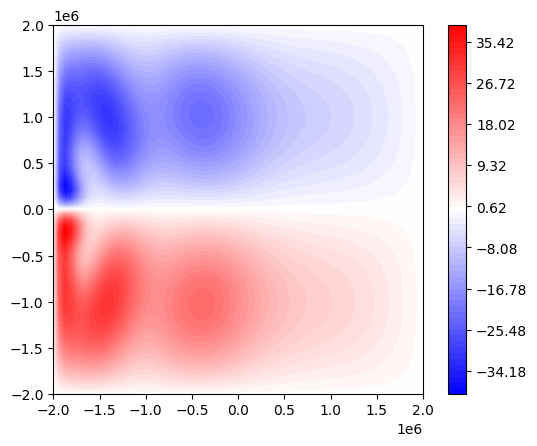

In [4]:
n_day = 24 * n_hour

model.initialize()
while model.n < 30 * n_day:
    model.steps(5 * n_day)
    print(f"{model.n // n_day=} {model.ke()=}")
assert model.n == 30 * n_day

plt.figure()
m = D * abs(model.fields["psi"]).max() / 1e6
plt.contourf(model.grid.X, model.grid.Y, D * model.fields["psi"] / 1.0e6,
             jnp.linspace(-m * (1 + 1.0e-10), m * (1 + 1.0e-10), 64), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()

We can see the start of the separating jet in this low resolution double gyre configuration.

Let's compute the eastward advective potential vorticity flux one Munk width from the western boundary in the northern half of the domain. To do this we compute the eastward velocity $u$, interpolate $u$ and the potential vorticity $q$, compute their product, and then use the trapezoidal rule.

In [5]:
def pv_flux(model):
    u = -model.grid.D_y(model.fields["psi"])
    x = jnp.array((-model.grid.L_x + jnp.cbrt(model.nu / model.beta),))
    y = jnp.linspace(0, model.grid.L_y, 1025)
    u_munk = model.grid.interpolate(u, x, y)[0, :]
    q_munk = model.grid.interpolate(model.fields["zeta"] + model.beta * model.grid.Y, x, y)[0, :]
    return trapezoid(u_munk * q_munk, y)


print(f"{pv_flux(model)=}")

pv_flux(model)=Array(-1.15568036, dtype=float64)


## Autodiff

Let's compute the reverse mode derivative of this PV flux with respect to the wind stress curl profile $Q$. Since JAX differentiates pure functions we first write a function which performs the entire calculation. Here we also apply a basic reverse mode checkpointing approach, checkpointing every time step.

In [6]:
def forward(Q):
    @jax.checkpoint
    def step(_, model):
        model = model.copy()
        model.step()
        return model

    model = CNAB2Solver(parameters)
    model.fields["Q"] = Q
    model = jax.lax.fori_loop(0, 30 * n_day, step, model)
    return pv_flux(model)

We can now apply reverse mode autodiff.

In [7]:
flux, vjp = jax.vjp(forward, model.fields["Q"])
print(f"{flux=}")
dflux_dual, = vjp(1.0)

flux=Array(-1.15568036, dtype=float64)


We need to be a little careful when we plot the result, as the result of a derivative of a functional is a dual space object &ndash; it is a linear functional which maps discrete functions to values. To plot the result we need to make use of a Riesz map, which uses an inner product to define a map from linear functionals to discrete functions. Specifically if $V$ is a real finite dimensional primal function space, and $g \in V^*$ is a dual space derivative, then we can define an associated primal space gradient $g^\sharp \in V$ via

$$\forall \phi \in V \qquad g ( \phi ) = \langle g^\sharp, \phi \rangle,$$

where $\langle \cdot, \cdot \rangle$ is the inner product which defines the Riesz map.

Here we use the Riesz map defined by the $L^2$ inner product. Conceptually, this re-weights the derivative to take account of cell areas.

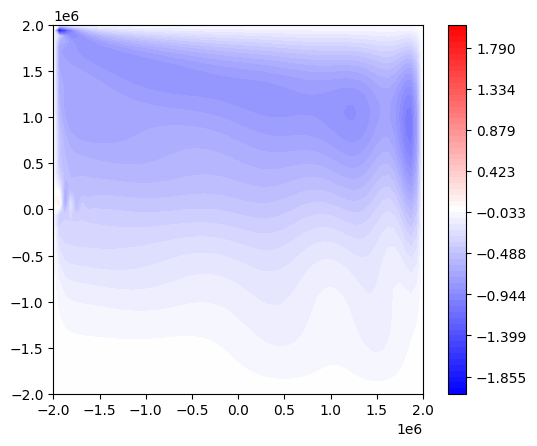

In [8]:
dflux_primal = dflux_dual / model.grid.W

plt.figure()
m = abs(dflux_primal).max()
plt.contourf(model.grid.X, model.grid.Y, dflux_primal,
             jnp.linspace(-m * (1 + 1.0e-10), m * (1 + 1.0e-10), 64), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()

If $g \in V^*$ is the derivative of a functional $J : V \rightarrow \mathbb{R}$ evaluated at some $Q \in V$ then we have, for some direction $\eta \in V$,

$$\frac{d}{d \alpha} J ( Q + \alpha \eta ) = g ( \eta ) = \langle g^\sharp, \eta \rangle,$$

where here $\alpha$ is a scalar.

In [9]:
Q_0 = tau_0 * jnp.pi / (D * rho_0 * model.grid.L_y)
eta = Q_0 * (jnp.sin(jnp.pi * (model.grid.X + model.grid.L_x) / (2 * model.grid.L_x))
             * jnp.sin(jnp.pi * (model.grid.Y + model.grid.L_y) / (2 * model.grid.L_y)))
dflux_primal_eta = jnp.tensordot(dflux_dual, eta)
print(f"{dflux_primal_eta=}")

dflux_primal_eta=Array(-0.86734156, dtype=float64)


We can compare with the result from finite differencing.

In [10]:
eps = 1.0e-5
dflux_primal_eta_fd = (forward(model.fields["Q"] + eps * eta) - forward(model.fields["Q"] - eps * eta)) / (2 * eps)
print(f"{dflux_primal_eta_fd=}")
assert abs(dflux_primal_eta - dflux_primal_eta_fd) < 1.0e-9 * abs(dflux_primal_eta_fd)

dflux_primal_eta_fd=Array(-0.86734156, dtype=float64)
